In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Wed Jan 24 19:43:06 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   33C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [4]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.init_log_sigma = 0
hp.const_sigma = False
hp.quantize = False
hp.prior_mu = 0.9999

hp.M = hp.n_prior_embeddings

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 3.814697265625e-06
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.19-7_uniform_notconst_1e-6/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 440475, model_list, optimizer_list)

total 0


### Dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [11]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

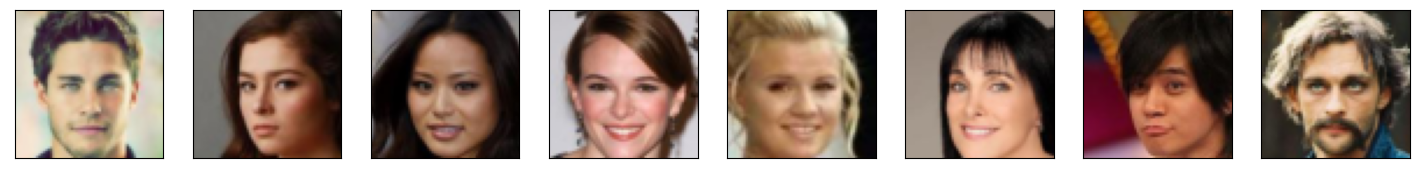

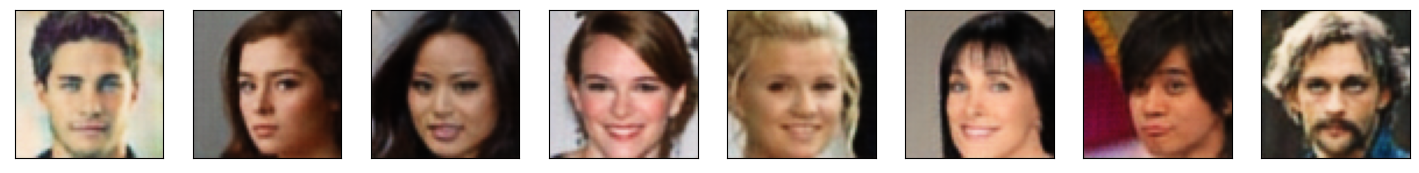

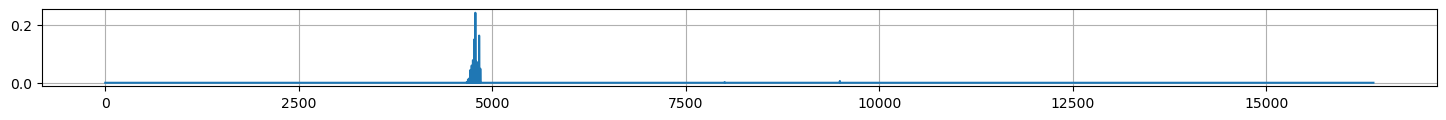

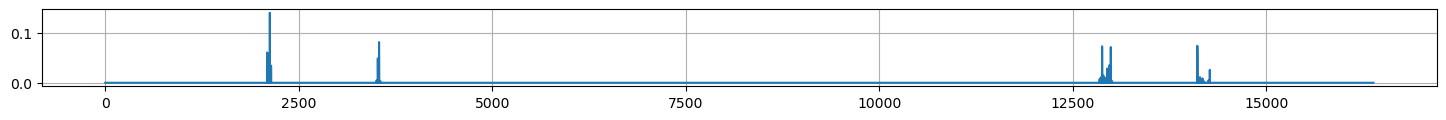

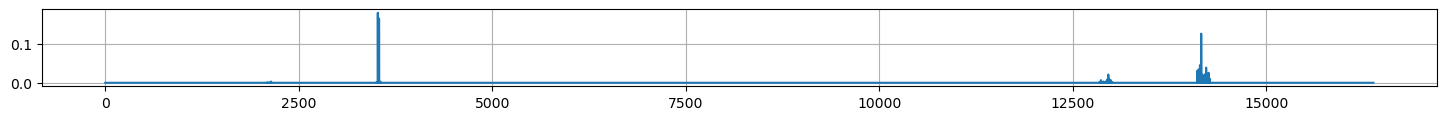

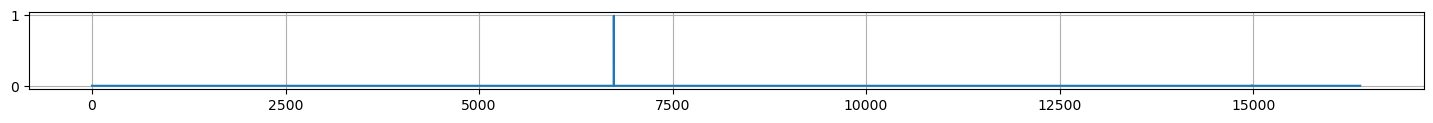

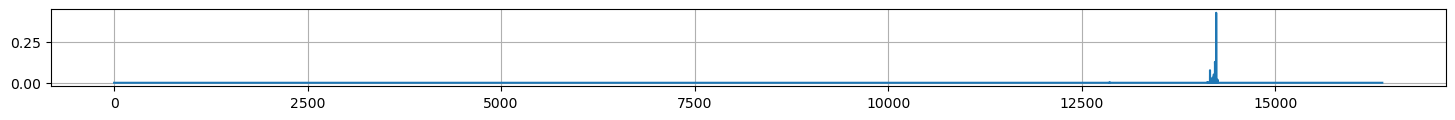

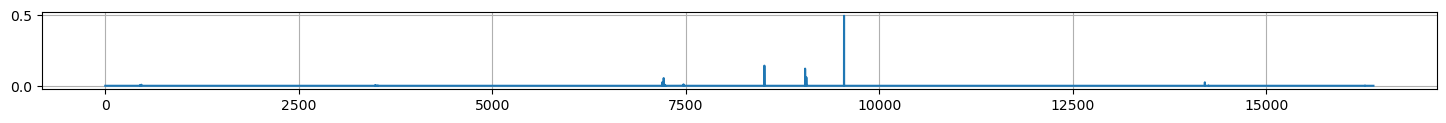

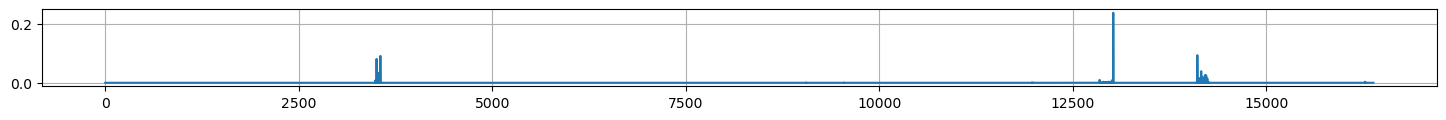

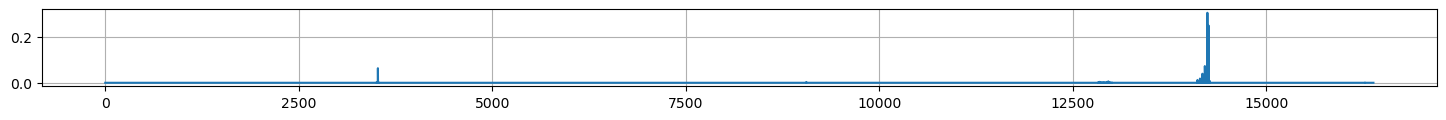

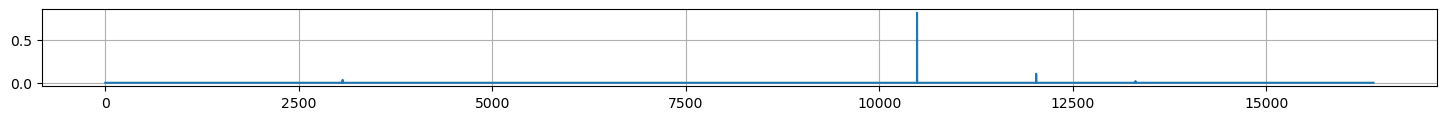

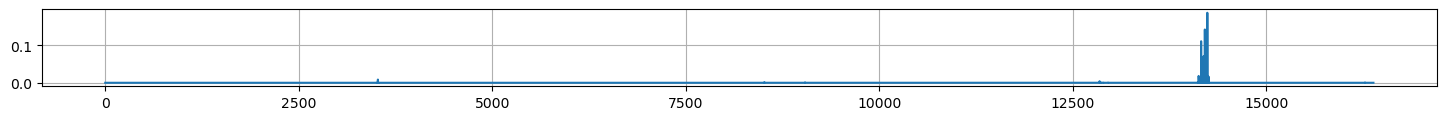

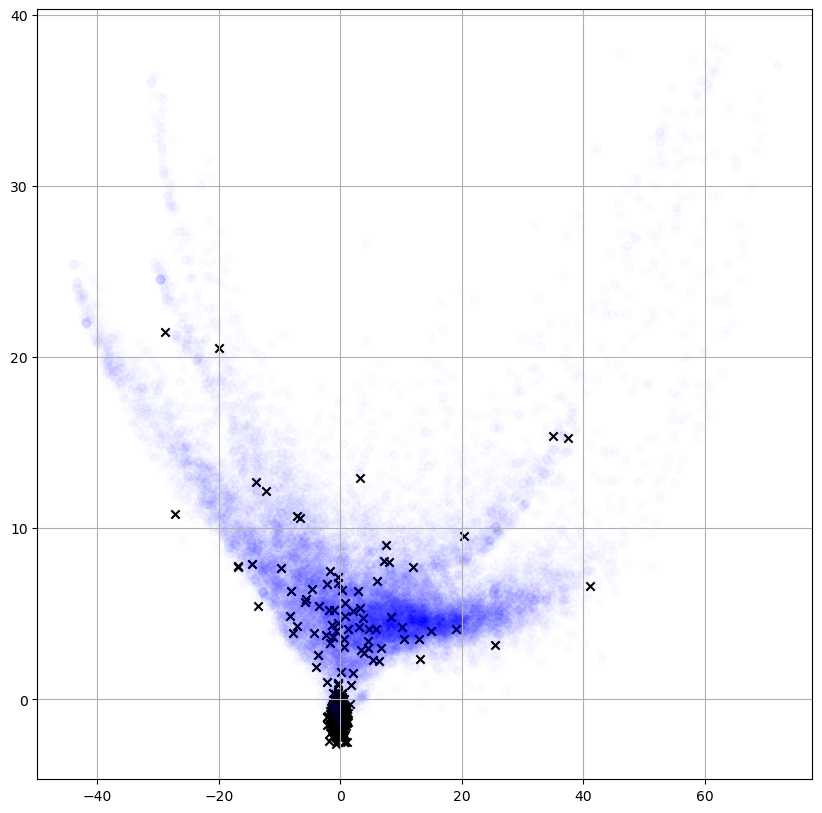

13001
lse_loss -25.975391387939453
commit_loss 1.6373906135559082
recon_loss 0.0006521957693621516
13002
lse_loss -21.93545150756836
commit_loss 1.6176702976226807
recon_loss 0.0007086574914865196
13003
lse_loss -25.928855895996094
commit_loss 1.8048830032348633
recon_loss 0.0006195228779688478
13004
lse_loss -27.094951629638672
commit_loss 1.6773436069488525
recon_loss 0.0005864535924047232
13005
lse_loss -21.075626373291016
commit_loss 1.574703574180603
recon_loss 0.0006798703107051551
13006
lse_loss -28.061580657958984
commit_loss 1.6695517301559448
recon_loss 0.0005599702708423138
13007
lse_loss -25.737037658691406
commit_loss 1.744338035583496
recon_loss 0.0005770473508164287
13008
lse_loss -25.428043365478516
commit_loss 1.5744497776031494
recon_loss 0.0005664533236995339
13009
lse_loss -26.28961181640625
commit_loss 1.5424751043319702
recon_loss 0.000624630250968039
13010
lse_loss -26.35641098022461
commit_loss 1.692253589630127
recon_loss 0.0006302035762928426
13011
lse_loss -2

lse_loss -25.673702239990234
commit_loss 1.753442645072937
recon_loss 0.0005611800588667393
13087
lse_loss -25.74443817138672
commit_loss 1.5140067338943481
recon_loss 0.000527110998518765
13088
lse_loss -25.465335845947266
commit_loss 1.6387741565704346
recon_loss 0.0005598015850409865
13089
lse_loss -27.78329086303711
commit_loss 1.7268052101135254
recon_loss 0.0007048518164083362
13090
lse_loss -26.906482696533203
commit_loss 1.7817809581756592
recon_loss 0.0005765203386545181
13091
lse_loss -24.797515869140625
commit_loss 1.5489505529403687
recon_loss 0.0006084420019760728
13092
lse_loss -25.49380111694336
commit_loss 1.6036654710769653
recon_loss 0.000653883907943964
13093
lse_loss -26.594280242919922
commit_loss 1.9265739917755127
recon_loss 0.0006738714873790741
13094
lse_loss -28.140174865722656
commit_loss 1.5185461044311523
recon_loss 0.0006264708936214447
13095
lse_loss -23.811870574951172
commit_loss 1.8987541198730469
recon_loss 0.0006592489662580192
13096
lse_loss -27.386

lse_loss -27.202743530273438
commit_loss 1.6489248275756836
recon_loss 0.0006454793037846684
13172
lse_loss -26.587059020996094
commit_loss 1.7225500345230103
recon_loss 0.0006248290883377194
13173
lse_loss -26.378780364990234
commit_loss 1.6887305974960327
recon_loss 0.0005565236788243055
13174
lse_loss -25.92245864868164
commit_loss 1.7574198246002197
recon_loss 0.0005629174411296844
13175
lse_loss -27.44152069091797
commit_loss 1.7776110172271729
recon_loss 0.0005861041136085987
13176
lse_loss -26.397502899169922
commit_loss 1.6731683015823364
recon_loss 0.0006305404822342098
13177
lse_loss -25.44677734375
commit_loss 1.7674741744995117
recon_loss 0.0006456387927755713
13178
lse_loss -26.339397430419922
commit_loss 1.6603951454162598
recon_loss 0.0005357008776627481
13179
lse_loss -27.150745391845703
commit_loss 1.5885560512542725
recon_loss 0.0005922276759520173
13180
lse_loss -26.646595001220703
commit_loss 1.61606764793396
recon_loss 0.0005212532705627382
13181
lse_loss -26.52630

lse_loss -28.26459503173828
commit_loss 1.5464568138122559
recon_loss 0.0005809356225654483
13256
lse_loss -25.869407653808594
commit_loss 1.607134461402893
recon_loss 0.0006737220101058483
13257
lse_loss -21.364093780517578
commit_loss 1.5749497413635254
recon_loss 0.0005417053471319377
13258
lse_loss -26.220584869384766
commit_loss 1.8053221702575684
recon_loss 0.0005712922429665923
13259
lse_loss -23.514724731445312
commit_loss 1.6497914791107178
recon_loss 0.0005143164307810366
13260
lse_loss -24.891773223876953
commit_loss 1.5490310192108154
recon_loss 0.0005668023368343711
13261
lse_loss -27.800800323486328
commit_loss 1.5576940774917603
recon_loss 0.0006123686907812953
13262
lse_loss -25.266738891601562
commit_loss 1.674142599105835
recon_loss 0.0005585410399362445
13263
lse_loss -27.38713836669922
commit_loss 1.663723349571228
recon_loss 0.0005430139135569334
13264
lse_loss -25.16454315185547
commit_loss 1.5376428365707397
recon_loss 0.0005782291991636157
13265
lse_loss -26.826

13340
lse_loss -26.66956329345703
commit_loss 1.560131549835205
recon_loss 0.0008516264497302473
13341
lse_loss -23.940410614013672
commit_loss 1.586548089981079
recon_loss 0.0006063610198907554
13342
lse_loss -25.02871322631836
commit_loss 1.680404782295227
recon_loss 0.0005890300963073969
13343
lse_loss -27.480140686035156
commit_loss 1.5980262756347656
recon_loss 0.0007196229416877031
13344
lse_loss -24.991931915283203
commit_loss 1.6865017414093018
recon_loss 0.0012662694789469242
13345
lse_loss -27.17177963256836
commit_loss 1.639418363571167
recon_loss 0.0006693194154649973
13346
lse_loss -25.083728790283203
commit_loss 1.5991482734680176
recon_loss 0.0007598150987178087
13347
lse_loss -23.923507690429688
commit_loss 1.4888924360275269
recon_loss 0.0006916901911608875
13348
lse_loss -26.01736831665039
commit_loss 1.4346455335617065
recon_loss 0.0007054986781440675
13349
lse_loss -26.820945739746094
commit_loss 1.5997713804244995
recon_loss 0.0005919418763369322
13350
lse_loss -26

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, latent_temp=1)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1e-6
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            log_sigma = model.latent.log_sigma.item()
            writer.add_scalar('log_sigma', log_sigma, step)
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            grad = torch.softmax(data['matrix'], dim=0)
            grad = grad.data.cpu().numpy()

            import matplotlib.pyplot as plt

            for i in np.random.randint(0, grad.shape[1], size=[10]):
                plt.figure(figsize=[18, 1])
                plt.plot(grad[:, i])
                plt.grid()
                plt.show()
            
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [25]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

done


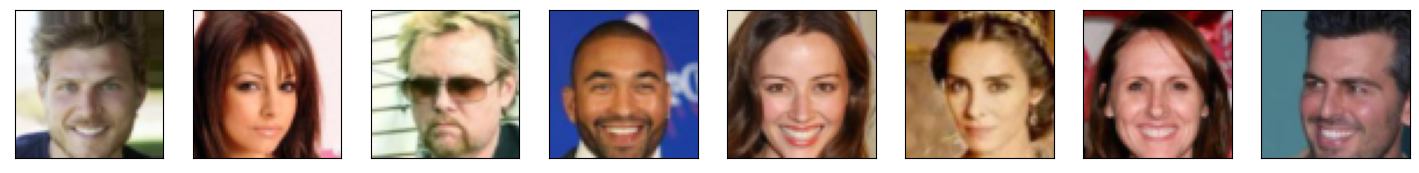

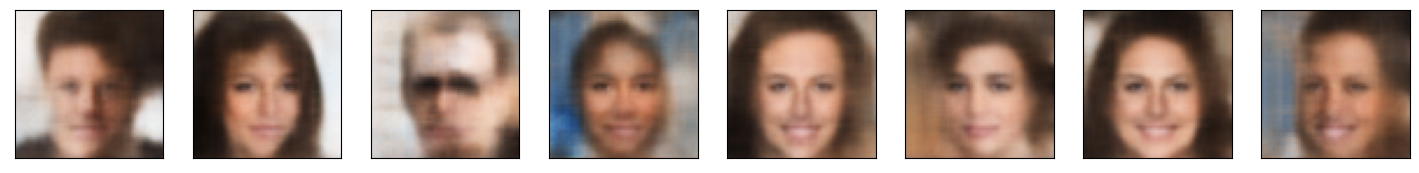

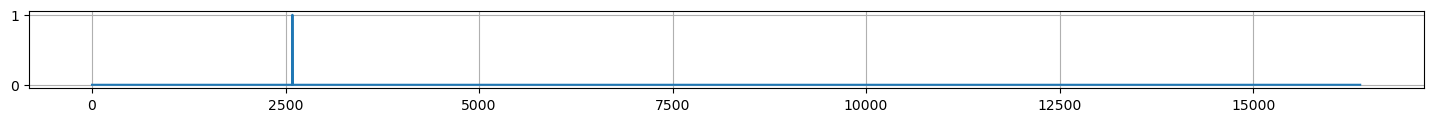

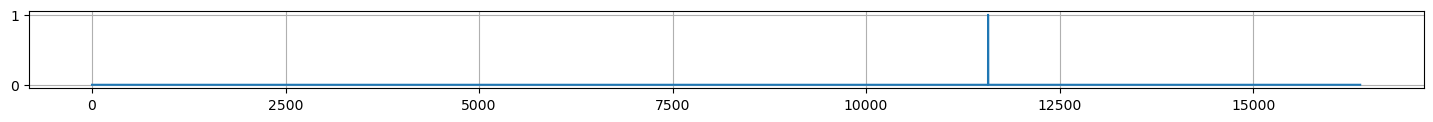

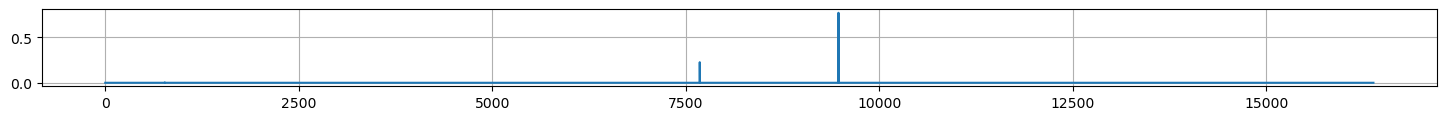

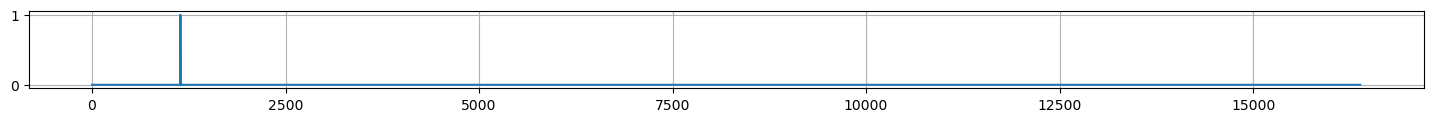

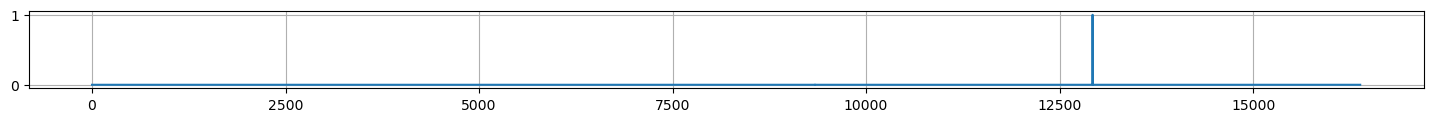

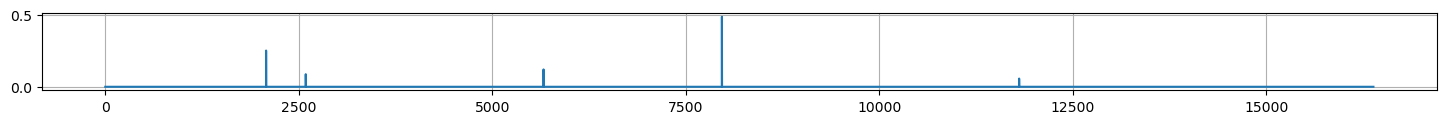

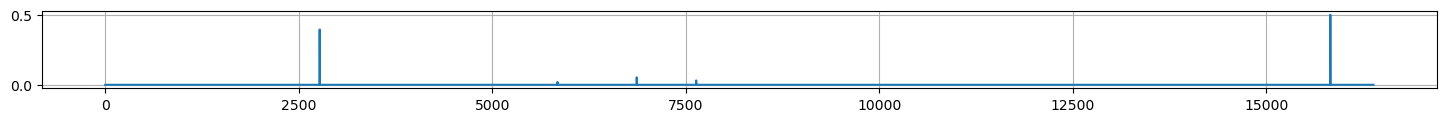

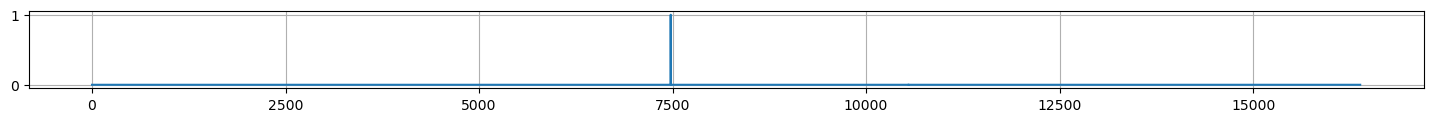

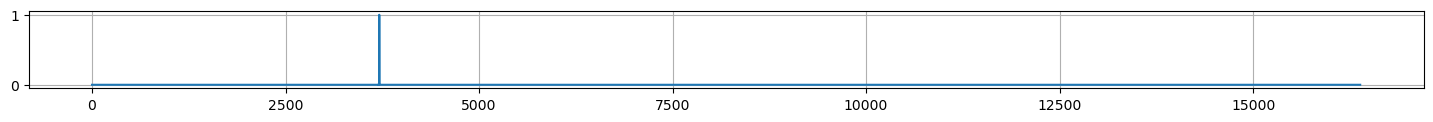

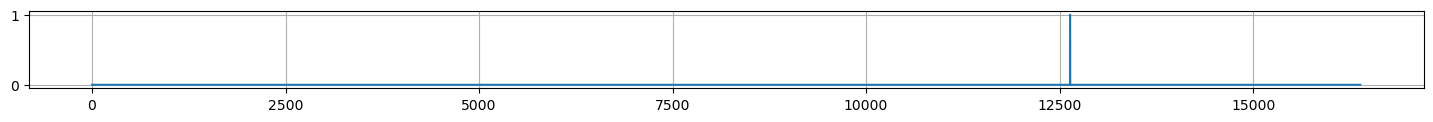

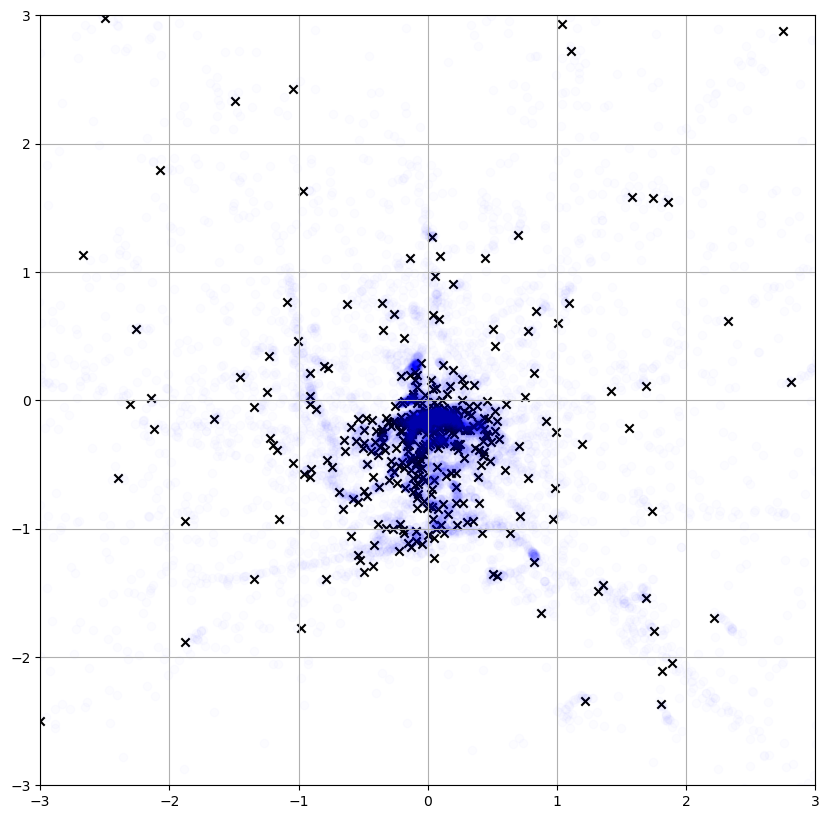

In [23]:
import matplotlib.pyplot as plt
display.clear_output()

x = data['x']
y = data['y']

plot(x)
plot(y)

grad = torch.softmax(data['matrix'], dim=0)
grad = grad.data.cpu().numpy()

import matplotlib.pyplot as plt

for i in np.random.randint(0, grad.shape[1], size=[10]):
    plt.figure(figsize=[18, 1])
    plt.plot(grad[:, i])
    plt.grid()
    plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
e = model.prior.prior.data.cpu().numpy()
pca.fit(e)
e_pca = pca.transform(e)
z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
plt.figure(figsize=[10, 10])
plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.grid()
plt.show() 

In [32]:
from tqdm import tqdm

belongs = []
for i, batch in tqdm(enumerate(train_loader)):
    data = preprocess(batch)

    # Forward
    model.eval()
    data = model(data, latent_temp=1)
    belongs.append(data['belong'])

    if i > 2:
        break

3it [00:00, 10.83it/s]


In [33]:
belongs = torch.stack(belongs, dim=0)
print(belongs.shape)

torch.Size([4, 16384, 512])


In [34]:
(belongs.sum(dim=[0, 1]) > 0).sum()

tensor(512, device='cuda:0')